# Random Forest Classifier Version 1 Model Using:
<p style="color:blue;">1. Data Source = df_signal_strength_inc_spy.csv from signal_prep.ipynb (Includes SPY  & Signal = 1 refers to Long & 0 refers to Long Cash)</p>
<p style="color:blue;">2. SMA Cross Over For Sectors & SPY,</p>
<p style="color:blue;">3. Cummulative Return Trend For Sectors & SPY,</p>
<p style="color:blue;">4. Multi-Period Volatility For Sectors & SPY, &</p>
<p style="color:blue;">5. Alpaca Price Source</p>

In [1]:
# Model Resource:  https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from pathlib import Path
import time
#import hvplot as plt

#Import SKLearn Library and CLasses
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from joblib import dump, load

import yfinance as yf
import pyfolio as pf
from pyfolio import timeseries 
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
print(f'Preparing to train, test, fit, and evaluate the Random Forest Classifier Model...\n')

Preparing to train, test, fit, and evaluate the Random Forest Classifier Model...



In [4]:
# Load model parameter file
df_random_forest_model_param = pd.read_csv('DataFiles/random_forest_model_parameters.csv')
df_random_forest_model_param

,n_estimators,max_depth,min_samples_split,verbose,random_state
0,500,5000,2,0,0


In [5]:
#################################
#         GLOBAL VARIABLES      #
#################################

# Day's per annum
n = 252

In [6]:
# Open signals file for all S&P500/SPY Sectors that was generated in the "signal_prep" notebook 
csv_path = Path('AutoOutputFiles/df_signal_strength_inc_spy.csv')
X = pd.read_csv(csv_path, index_col="Date", infer_datetime_format=True, parse_dates=True)
X.head()

,SPY_SMA_Signal,XLE_SMA_Signal,XLB_SMA_Signal,XLI_SMA_Signal,XLY_SMA_Signal,XLP_SMA_Signal,XLV_SMA_Signal,XLF_SMA_Signal,XLK_SMA_Signal,XLC_SMA_Signal,...,XLB_Std_Signal,XLI_Std_Signal,XLY_Std_Signal,XLP_Std_Signal,XLV_Std_Signal,XLF_Std_Signal,XLK_Std_Signal,XLC_Std_Signal,XLU_Std_Signal,XLRE_Std_Signal
Date,,,,,,,,,,,,,,,,,,,,,
2018-06-21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-06-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-06-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-06-26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-06-27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Shift DataFrame Index by 1 to ensure we are using current day's values to predict the next days target value and drop NaNs that get produced in the first row from shift

signal_shift = 1
X = X.shift(signal_shift).dropna()

#print(f'Feature dataset is ready for use and has a shape of {X.shape}')
X.head()

,SPY_SMA_Signal,XLE_SMA_Signal,XLB_SMA_Signal,XLI_SMA_Signal,XLY_SMA_Signal,XLP_SMA_Signal,XLV_SMA_Signal,XLF_SMA_Signal,XLK_SMA_Signal,XLC_SMA_Signal,...,XLB_Std_Signal,XLI_Std_Signal,XLY_Std_Signal,XLP_Std_Signal,XLV_Std_Signal,XLF_Std_Signal,XLK_Std_Signal,XLC_Std_Signal,XLU_Std_Signal,XLRE_Std_Signal
Date,,,,,,,,,,,,,,,,,,,,,
2018-06-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-06-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-06-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-06-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-06-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Open daily returns that were constructed in the data prep module

csv_path2 = Path('AutoOutputFiles/df_benchmarks_daily_rtn.csv')
sector_daily_returns = pd.read_csv(csv_path2, index_col="Date", infer_datetime_format=True, parse_dates=True)
sector_daily_returns.head()

,SPY,XLE,XLB,XLI,XLY,XLP,XLV,XLF,XLK,XLC,XLU,XLRE,SPTS
Date,,,,,,,,,,,,,
2018-06-20,0.001706,0.004684,-0.003759,0.000273,0.004742,0.001175,0.002121,-0.003472,0.002521,0.012410,0.000199,0.011111,-0.000339
2018-06-21,-0.006341,-0.019446,-0.010292,-0.012012,-0.007213,0.001761,-0.005527,-0.001834,-0.007823,-0.006129,0.003384,0.005965,0.000678
2018-06-22,0.001750,0.021597,0.013692,0.003040,-0.001345,0.008203,0.004139,-0.005328,-0.003098,0.004376,0.006944,0.008115,-0.000339
2018-06-25,-0.013469,-0.021939,-0.014703,-0.012397,-0.021825,0.004843,-0.008951,-0.010344,-0.020621,-0.020598,0.016749,-0.002012,0.000339
2018-06-26,0.001993,0.013866,0.003644,0.003208,0.006978,-0.004049,-0.002971,-0.003733,0.003750,0.001662,0.000000,0.005429,0.000339


In [9]:
# Construct a data Frame that only includes daily prices for SPY

spy_daily_returns_df = sector_daily_returns.copy()
spy_daily_returns_df = spy_daily_returns_df.drop(columns=['XLE', 'XLB', 'XLI', 'XLY', 'XLP', 'XLV', 'XLF', 'XLK', 'XLC', 'XLU', 'XLRE', 'SPTS'])
spy_daily_returns_df.rename(columns = {list(spy_daily_returns_df)[0]:'daily_return'}, inplace=True)
#print(f'The DataFrame holding SPY daily historical returns, spy_daily_returns_df, has a shape of {spy_daily_returns_df.shape}')
spy_daily_returns_df.head()

,daily_return
Date,
2018-06-20,0.001706
2018-06-21,-0.006341
2018-06-22,0.001750
2018-06-25,-0.013469
2018-06-26,0.001993


In [10]:
# Construct a data frame with the closing price levels for SPY

csv_path3 = Path('AutoOutputFiles/df_benchmarks_closing_prices.csv')
sector_daily_prices = pd.read_csv(csv_path3, index_col="Date", infer_datetime_format=True, parse_dates=True)
sector_daily_prices.head()

,SPY,XLE,XLB,XLI,XLY,XLP,XLV,XLF,XLK,XLC,XLU,XLRE,SPTS
Date,,,,,,,,,,,,,
2018-06-19,275.51,74.73,58.52,73.24,111.77,51.05,84.85,27.360,71.40,49.96,50.22,31.500,29.52
2018-06-20,275.98,75.08,58.30,73.26,112.30,51.11,85.03,27.265,71.58,50.58,50.23,31.850,29.51
2018-06-21,274.23,73.62,57.70,72.38,111.49,51.20,84.56,27.215,71.02,50.27,50.40,32.040,29.53
2018-06-22,274.71,75.21,58.49,72.60,111.34,51.62,84.91,27.070,70.80,50.49,50.75,32.300,29.52
2018-06-25,271.01,73.56,57.63,71.70,108.91,51.87,84.15,26.790,69.34,49.45,51.60,32.235,29.53


In [11]:
spy_daily_prices_df = sector_daily_prices.drop(columns=['XLE', 'XLB', 'XLI', 'XLY', 'XLP', 'XLV', 'XLF', 'XLK', 'XLC', 'XLU', 'XLRE', 'SPTS'])
spy_daily_prices_df.rename(columns = {list(spy_daily_prices_df)[0]:'Close'}, inplace=True)
#spy_daily_prices_df

In [12]:
# Concatenate the data frames for the trading purposes
df_spy = pd.concat([spy_daily_prices_df, spy_daily_returns_df], axis='columns', join='inner')

# Construct the dependent variable
df_spy['Positive Return'] = df_spy['daily_return']
df_spy['Positive Return'] = np.where(df_spy['daily_return'] > 0, 1, 0)
df_spy.head()

,Close,daily_return,Positive Return
Date,,,
2018-06-20,275.98,0.001706,1
2018-06-21,274.23,-0.006341,0
2018-06-22,274.71,0.001750,1
2018-06-25,271.01,-0.013469,0
2018-06-26,271.55,0.001993,1


In [13]:
df_trading_signals = pd.concat([df_spy, X], axis='columns', join='inner')
print(f'The DataFrame named "df_trading_signals" constructed to hold SPY closing price levels, SPY daily returns, indication of positive, 1, and negative, 0, SPY returns.\n')
print(f'"df_trading_signals" has a shape of {df_trading_signals.shape}\n')
df_trading_signals.to_csv('AutoOutputFiles/df_trading_signals_random_forest_version_0001.csv')
df_trading_signals.head()

The DataFrame named "df_trading_signals" constructed to hold SPY closing price levels, SPY daily returns, indication of positive, 1, and negative, 0, SPY returns.

"df_trading_signals" has a shape of (803, 39)



,Close,daily_return,Positive Return,SPY_SMA_Signal,XLE_SMA_Signal,XLB_SMA_Signal,XLI_SMA_Signal,XLY_SMA_Signal,XLP_SMA_Signal,XLV_SMA_Signal,...,XLB_Std_Signal,XLI_Std_Signal,XLY_Std_Signal,XLP_Std_Signal,XLV_Std_Signal,XLF_Std_Signal,XLK_Std_Signal,XLC_Std_Signal,XLU_Std_Signal,XLRE_Std_Signal
Date,,,,,,,,,,,,,,,,,,,,,
2018-06-22,274.71,0.001750,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-06-25,271.01,-0.013469,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-06-26,271.55,0.001993,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-06-27,269.27,-0.008396,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-06-28,270.95,0.006239,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# Assign Training and Testing Windows
training_start = df_trading_signals.index.min().strftime(format='%Y-%m-%d')

# June 29, 2018 is a Friday
training_end = '2021-01-27'

# Construct testing start and end dates
# July 2, 2018 is the first business day following June 29, 2018
testing_start = '2021-01-28'
testing_end = df_trading_signals.index.max().strftime(format='%Y-%m-%d')

In [15]:
# Seperate X and Y Training Datasets
x_train = X[training_start:training_end]
y_train = df_trading_signals['Positive Return'][training_start:training_end]
#x_train.tail()
#y_train.tail()

In [16]:
# Seperate X and Y Testing Datasets
x_test = X[testing_start:testing_end]
y_test = df_trading_signals['Positive Return'][testing_start:testing_end]
#x_test.tail()
#y_test.tail()

In [17]:
# Random Forest Classifier Paramerters

# n_estimators: int, default=100
#    The number of trees in the forest.

# max_depth: int, default=None.  
#    The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

# min_samples_split: int or float, default=2
#    The minimum number of samples required to split an internal node:
#    If int, then consider min_samples_split as the minimum number.
#    If float, then min_samples_split is a fraction and ceil(min_samples_split * n_samples) are the minimum number of samples for each split.

# verbose: int, default=0
#    Controls the verbosity when fitting and predicting.

# max_features{“auto”, “sqrt”, “log2”}, int or float, default=”auto”
#    The number of features to consider when looking for the best split:
#    If int, then consider max_features features at each split.
#    If float, then max_features is a fraction and round(max_features * n_features) features are considered at each split.
#    If “auto”, then max_features=sqrt(n_features).
#    If “sqrt”, then max_features=sqrt(n_features) (same as “auto”).
#    If “log2”, then max_features=log2(n_features).
#    If None, then max_features=n_features.
#    Note: the search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than max_features features.

estimators_num = int(df_random_forest_model_param['n_estimators'].values)
depth_max = int(df_random_forest_model_param['max_depth'].values)
verbose_state = int(df_random_forest_model_param['verbose'].values)
features_max = 'auto'
state_random = int(df_random_forest_model_param['random_state'].values)

# Confirm the parameters that are being used for building, training, and testing the model
#print(f'\n')
print(f'-'*55)
print(f'Training Data Sets:')
print(f'Training Start: {training_start}')
print(f'Training End: {training_end}')
print(f'Feature (Indepenendent Variables) Training Size: {len(x_train)}')
print(f'Target (Depenendent Variables) Training Size: {len(y_train)}')

print(f'-'*55)

print(f'Testing Data Sets:')
print(f'Testing Start: {testing_start}')
print(f'Testing End: {testing_end}')
print(f'Feature (Indepenendent Variables) Testing Size: {len(x_test)}')
print(f'Target (Depenendent Variables) Testing Size: {len(y_test)}')

print(f'-'*55)

print(f'The Random Forst Paramerters:')
print(f'n_estimators = {estimators_num}')
print(f'max_depth = {depth_max}')
print(f'random_state = {state_random}')
print(f'-'*55)
print(f'\n')

-------------------------------------------------------
Training Data Sets:
Training Start: 2018-06-22
Training End: 2021-01-27
Feature (Indepenendent Variables) Training Size: 651
Target (Depenendent Variables) Training Size: 651
-------------------------------------------------------
Testing Data Sets:
Testing Start: 2021-01-28
Testing End: 2021-09-02
Feature (Indepenendent Variables) Testing Size: 152
Target (Depenendent Variables) Testing Size: 152
-------------------------------------------------------
The Random Forst Paramerters:
n_estimators = 500
max_depth = 5000
random_state = 0
-------------------------------------------------------




In [18]:
# Instantiate, Define, & fit the model
model = RandomForestClassifier(
    n_estimators = estimators_num,
    max_depth = depth_max, 
    max_features = features_max, 
    random_state = state_random, 
    verbose = verbose_state
)
model.fit(x_train, y_train)

# Make a prediction of "y" values from the x test dataset
predictions = model.predict(x_test)

# Assesmble actual y data (y_test) with predicted y data (from just above) into two columns in a dataframe:
results = y_test.to_frame()
results['Predicted Value'] = predictions
results.to_csv('AutoOutputFiles/results_testing.csv')

# Add a difference column to data frame, then plot to better visualize when actual and predicted are NOT equal
results['Predicted minus Actual'] = results['Predicted Value'] - results['Positive Return']
results.tail()

,Positive Return,Predicted Value,Predicted minus Actual
Date,,,
2021-08-27,1,1,0
2021-08-30,1,1,0
2021-08-31,0,1,1
2021-09-01,1,1,0
2021-09-02,1,1,0


In [19]:
df_performance_results = pd.concat([results, df_trading_signals], axis='columns', join='inner')
df_performance_results['SPY_Position'] = df_performance_results['Predicted Value'] * df_performance_results['daily_return']
df_performance_results['Strategy_Cum_Rtn'] = ( 1 + df_performance_results['SPY_Position']).cumprod()
df_performance_results['SPY_Cum_Rtn'] = ( 1 + df_performance_results['daily_return']).cumprod()
df_performance_results['Treasury'] = sector_daily_returns['SPTS']
df_performance_results.to_csv('AutoOutputFiles/df_performance_results_random_forest.csv')
df_performance_results

,Positive Return,Predicted Value,Predicted minus Actual,Close,daily_return,Positive Return,SPY_SMA_Signal,XLE_SMA_Signal,XLB_SMA_Signal,XLI_SMA_Signal,...,XLV_Std_Signal,XLF_Std_Signal,XLK_Std_Signal,XLC_Std_Signal,XLU_Std_Signal,XLRE_Std_Signal,SPY_Position,Strategy_Cum_Rtn,SPY_Cum_Rtn,Treasury
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-28,1,0,-1,377.600,0.008439,1,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,1.000000,1.008439,-0.000163
2021-01-29,0,1,1,370.190,-0.019624,0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,-0.019624,0.980376,0.988650,0.000163
2021-02-01,1,1,0,376.180,0.016181,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.016181,0.996239,1.004647,0.000163
2021-02-02,1,1,0,381.540,0.014248,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.014248,1.010434,1.018962,-0.000326
2021-02-03,1,1,0,381.860,0.000839,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000839,1.011282,1.019816,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-27,1,1,0,450.190,0.008784,1,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.008784,1.148974,1.202302,0.000326
2021-08-30,1,1,0,452.220,0.004509,1,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.004509,1.154155,1.207724,0.000163
2021-08-31,0,1,1,451.610,-0.001349,0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,-0.001349,1.152599,1.206094,0.000326


In [ ]:
# Retain should Pyfolio fail.  Only retaining in this module and deleting code block from other random forest model versions
# Calculate Full Period Risk Adjusted Performance Results

#annualized_return_strategy = df_performance_results['SPY_Position'].mean() * n
#annualized_return_spy = df_performance_results['daily_return'].mean() * n

#annualized_vol_strategy = df_performance_results['SPY_Position'].std() * np.sqrt(n)
#annualized_vol_spy = df_performance_results['daily_return'].std() * np.sqrt(n)

#sharpe_ratio_strategy = annualized_return_strategy / annualized_vol_strategy
#sharpe_ratio_spy = annualized_return_spy / annualized_vol_spy

#variance_strategy = df_performance_results['SPY_Position'].var()
#variance_spy = df_performance_results['daily_return'].var()

#beta_strategy = df_performance_results['SPY_Position'].cov(df_performance_results['daily_return']) / variance_spy

In [21]:
# Retain should Pyfolio fail.  Only retaining in this module and deleting code block from other random forest model versions
# As long as Pyfolio continues to work, the following is not required

#dash_size = 55

#print(f'_'*dash_size)
#print()
#print(f'FULL TEST PERIOD PERFORMANCE RESULTS\nVALIDATE PYFOLIO & INCLUDES BETA')
#print(f'_'*dash_size)
#print(f'Strategy Annualized Return     = {annualized_return_strategy}')
#print(f'SPY Annualized Return          = {annualized_return_spy}')
#print(f'-'*dash_size)
#print(f'Strategy Annualized Volatility = {annualized_vol_strategy}')
#print(f'SPY Annualized Volatility      = {annualized_vol_spy}')
#print(f'-'*dash_size)
#print(f'Strategy Annualized SR         = {sharpe_ratio_strategy}')
#print(f'SPY Annualized SR              = {sharpe_ratio_spy}')
#print(f'-'*dash_size)
#print(f'Strategy Beta                  = {beta_strategy}')
#print(f'_'*dash_size)

In [22]:
# Highlights text on Master_Algo_Notebook.ipynb
print("\033[1;37;40m \033[2;37:40m          PYFOLIO PERFORMANCE TEAR SHEETS          \033[0;37;40m")

 [2;37:40m          PYFOLIO PERFORMANCE TEAR SHEETS          


In [23]:
# Modify data frame dates to confirm to Pyfolio date requirements
df = df_performance_results
df = df.tz_localize("UTC")

In [24]:
algo_performance_series = df['SPY_Position']
spy_performance_series = df['daily_return']

perf_func = timeseries.perf_stats 
perf_stats_all = perf_func(returns=algo_performance_series, factor_returns=spy_performance_series, positions=None, transactions=None, turnover_denom="USD")
perf_stats_all.to_csv('AutoOutputFiles/random_forest_model_1_pyfolio_performance.csv')

In [25]:
print(f'\n\nTRADING ALGO TEST PERIOD PERFORMANCE RESULTS FROM PYFOLIO:\n{perf_stats_all}')



TRADING ALGO TEST PERIOD PERFORMANCE RESULTS FROM PYFOLIO:
Annual return          0.272853
Cumulative returns     0.156644
Annual volatility      0.114913
Sharpe ratio           2.157599
Calmar ratio           6.444786
Stability              0.857493
Max drawdown          -0.042337
Omega ratio            1.511318
Sortino ratio          3.317955
Skew                  -0.212791
Kurtosis               1.769973
Tail ratio             1.295474
Daily value at risk   -0.013494
Alpha                 -0.035810
Beta                   0.877481
dtype: float64


In [26]:
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func(returns=spy_performance_series, factor_returns=spy_performance_series, positions=None, transactions=None, turnover_denom="USD")
perf_stats_all.to_csv('AutoOutputFiles/random_forest_spy_pyfolio_performance.csv')

In [27]:
print(f'\n\nSPY TEST PERIOD PERFORMANCE RESULTS FROM PYFOLIO:\n{perf_stats_all}')



SPY TEST PERIOD PERFORMANCE RESULTS FROM PYFOLIO:
Annual return          0.372285
Cumulative returns     0.210327
Annual volatility      0.122323
Sharpe ratio           2.649632
Calmar ratio           9.159931
Stability              0.936632
Max drawdown          -0.040643
Omega ratio            1.560759
Sortino ratio          4.113647
Skew                  -0.285335
Kurtosis               0.902857
Tail ratio             1.222551
Daily value at risk   -0.014125
Alpha                  0.000000
Beta                   1.000000
dtype: float64


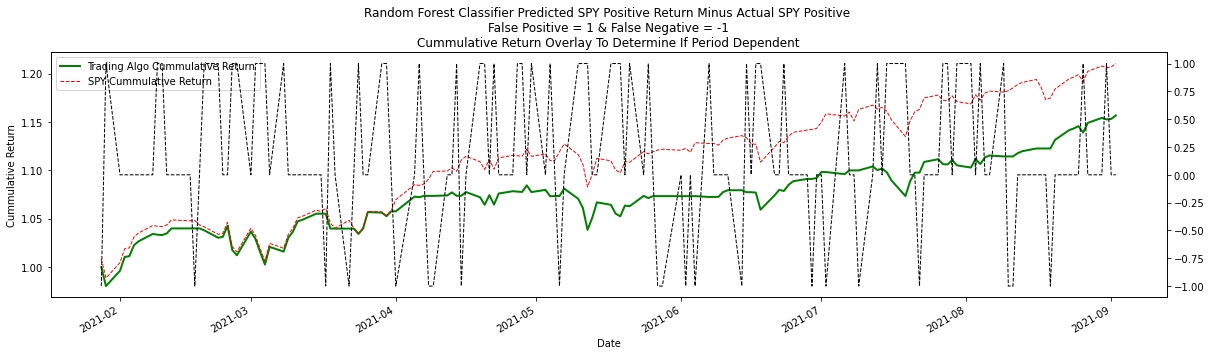

In [28]:
ax = df_performance_results['Strategy_Cum_Rtn'].plot(
    kind='line', label='Trading Algo Cummulative', legend=True, 
    title='Random Forest Classifier Predicted SPY Positive Return Minus Actual SPY Positive \nFalse Positive = 1 & False Negative = -1\nCummulative Return Overlay To Determine If Period Dependent', 
    secondary_y=False, 
    linewidth=2, 
    style='g', 
    figsize=(20,5)
)

ax2 = df_performance_results['SPY_Cum_Rtn'].plot(
    kind='line', 
    label='SPY Cummulative Return', 
    legend=True, 
    secondary_y=False, 
    linestyle='dashed', 
    linewidth=1, 
    style='r', 
    figsize=(20,5)
)

ax3 = df_performance_results['Predicted minus Actual'].plot(
    kind='line', 
    label='SPY Cummulative Return', 
    legend=True, 
    secondary_y=True, 
    linestyle='dashed', 
    linewidth=1, 
    style='black', 
    figsize=(20,5)
)


ax.legend(loc=0)
ax.set_ylabel('Cummulative Return')

ax.legend(
    [
        'Trading Algo Cummulative Return',
        'SPY Cummulative Return'
    ]
)

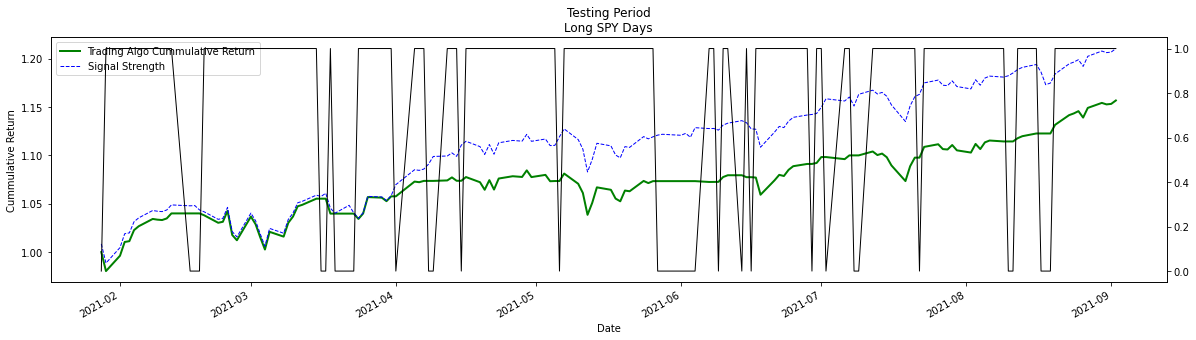

In [29]:
ax = df_performance_results['Strategy_Cum_Rtn'].plot(
    kind='line', label='Trading Algo Cummulative', legend=True, 
    title='Testing Period\nLong SPY Days', secondary_y=False, linewidth=2, style='g', figsize=(20,5))

ax2 = df_performance_results['SPY_Cum_Rtn'].plot(
    kind='line', label='SPY Cummulative Return', legend=True, secondary_y=False, linestyle='dashed', linewidth=1, style='b', figsize=(20,5))

ax3 = df_performance_results['Predicted Value'].plot(
    kind='line', label='SPY Cummulative Return', legend=True, secondary_y=True, linewidth=1, style='black', figsize=(20,5))


ax.legend(loc=0)
ax.set_ylabel('Cummulative Return')

ax.legend(
    [
        'Trading Algo Cummulative Return',
        'Signal Strength'
    ]
)

In [30]:
print("\033[1;37;40m \033[2;37:40m Random Forest Classifier Trading Algo Testing Period  \033[0;37;40m")
print("\033[1;37;40m \033[2;37:40m             Pyfolio Performance Tear Sheet            \033[0;37;40m")
print('')

 [2;37:40m Random Forest Classifier Trading Algo Testing Period  
 [2;37:40m             Pyfolio Performance Tear Sheet            



Start date,2021-01-28
End date,2021-09-02
Total months,7
,Backtest
Annual return,27.285%
Cumulative returns,15.664%
Annual volatility,11.491%
Sharpe ratio,2.16
Calmar ratio,6.44
Stability,0.86
Max drawdown,-4.234%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,4.23,2021-04-29,2021-05-12,2021-06-24,41
1,3.84,2021-02-24,2021-03-04,2021-03-11,12
2,2.77,2021-07-12,2021-07-19,2021-07-23,10
3,1.98,2021-03-17,2021-03-24,2021-03-26,8
4,1.96,2021-01-28,2021-01-29,2021-02-02,4


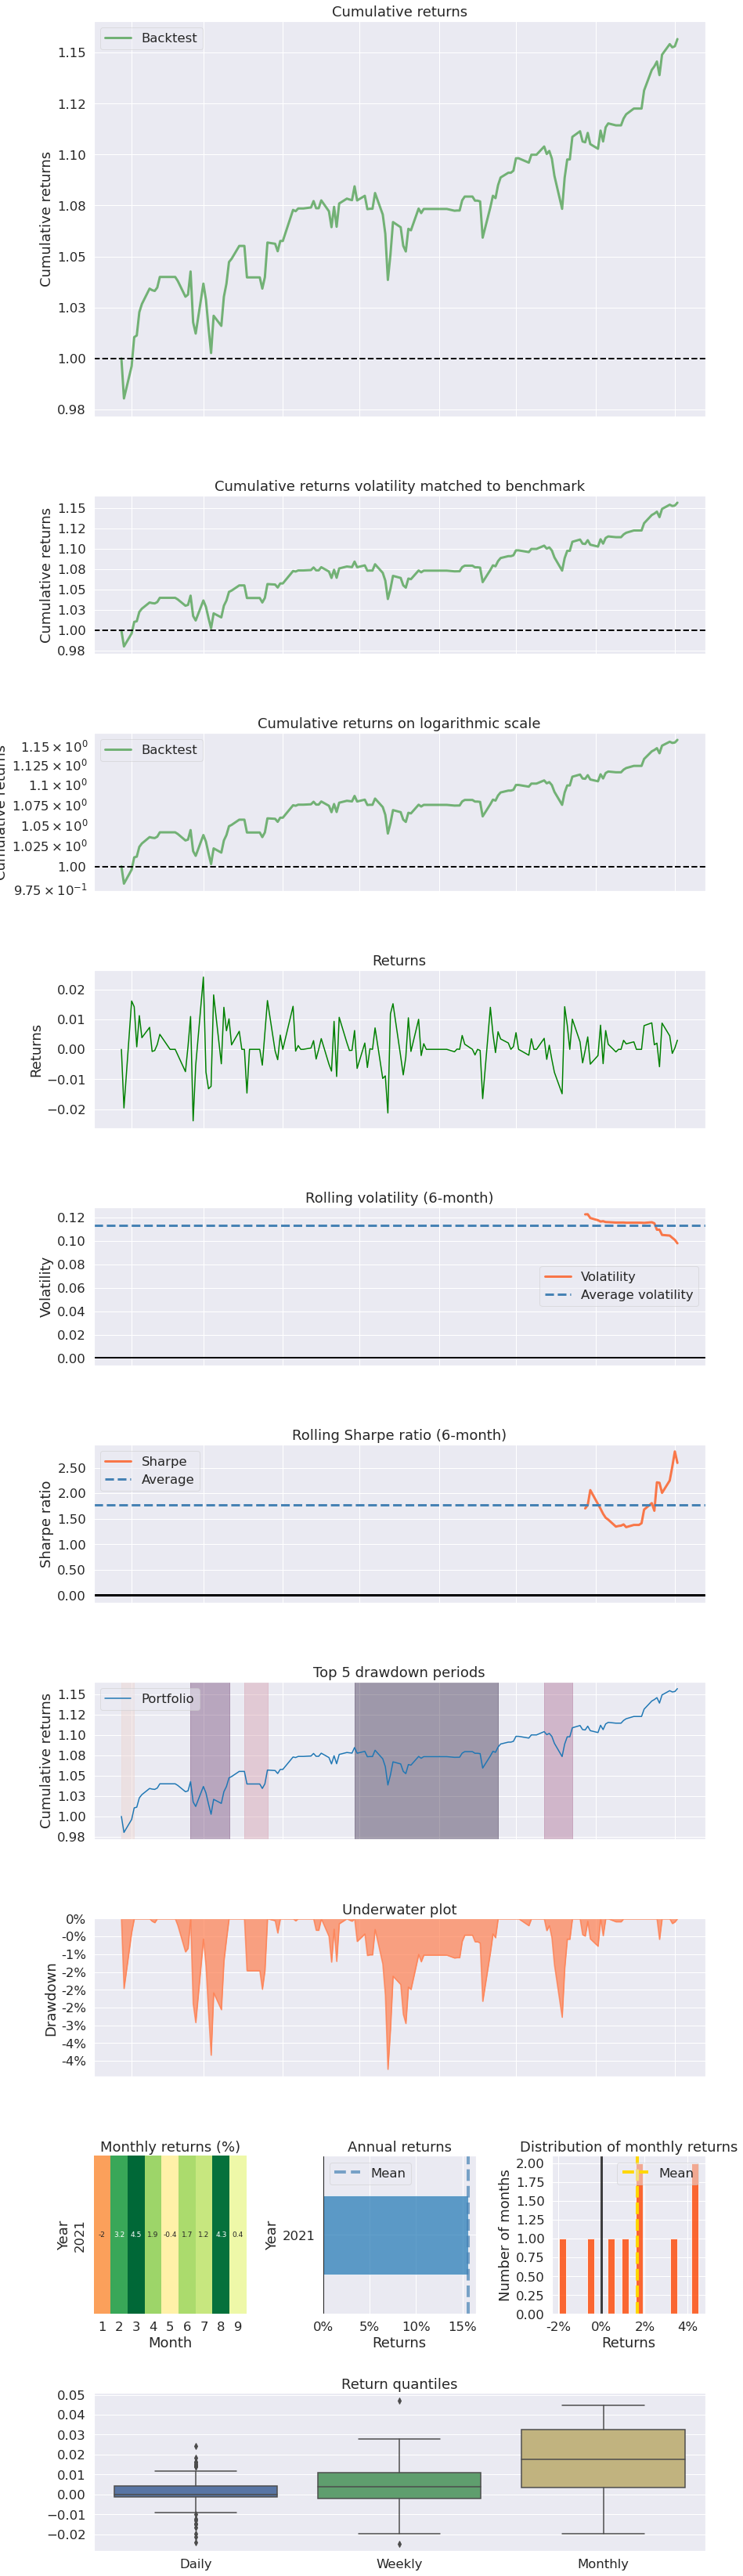

In [31]:
pf.create_returns_tear_sheet(algo_performance_series)

In [32]:
print('\n')
print("\033[1;37;40m \033[2;37:40m                   SPY Testing Period                  \033[0;37;40m")
print("\033[1;37;40m \033[2;37:40m             Pyfolio Performance Tear Sheet            \033[0;37;40m")
print('')



 [2;37:40m                   SPY Testing Period                  
 [2;37:40m             Pyfolio Performance Tear Sheet            



Start date,2021-01-28
End date,2021-09-02
Total months,7
,Backtest
Annual return,37.228%
Cumulative returns,21.033%
Annual volatility,12.232%
Sharpe ratio,2.65
Calmar ratio,9.16
Stability,0.94
Max drawdown,-4.064%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,4.06,2021-02-12,2021-03-04,2021-03-11,20
1,3.94,2021-05-07,2021-05-12,2021-06-04,21
2,2.77,2021-07-12,2021-07-19,2021-07-23,10
3,2.44,2021-03-17,2021-03-24,2021-04-01,12
4,2.42,2021-06-14,2021-06-18,2021-06-25,10


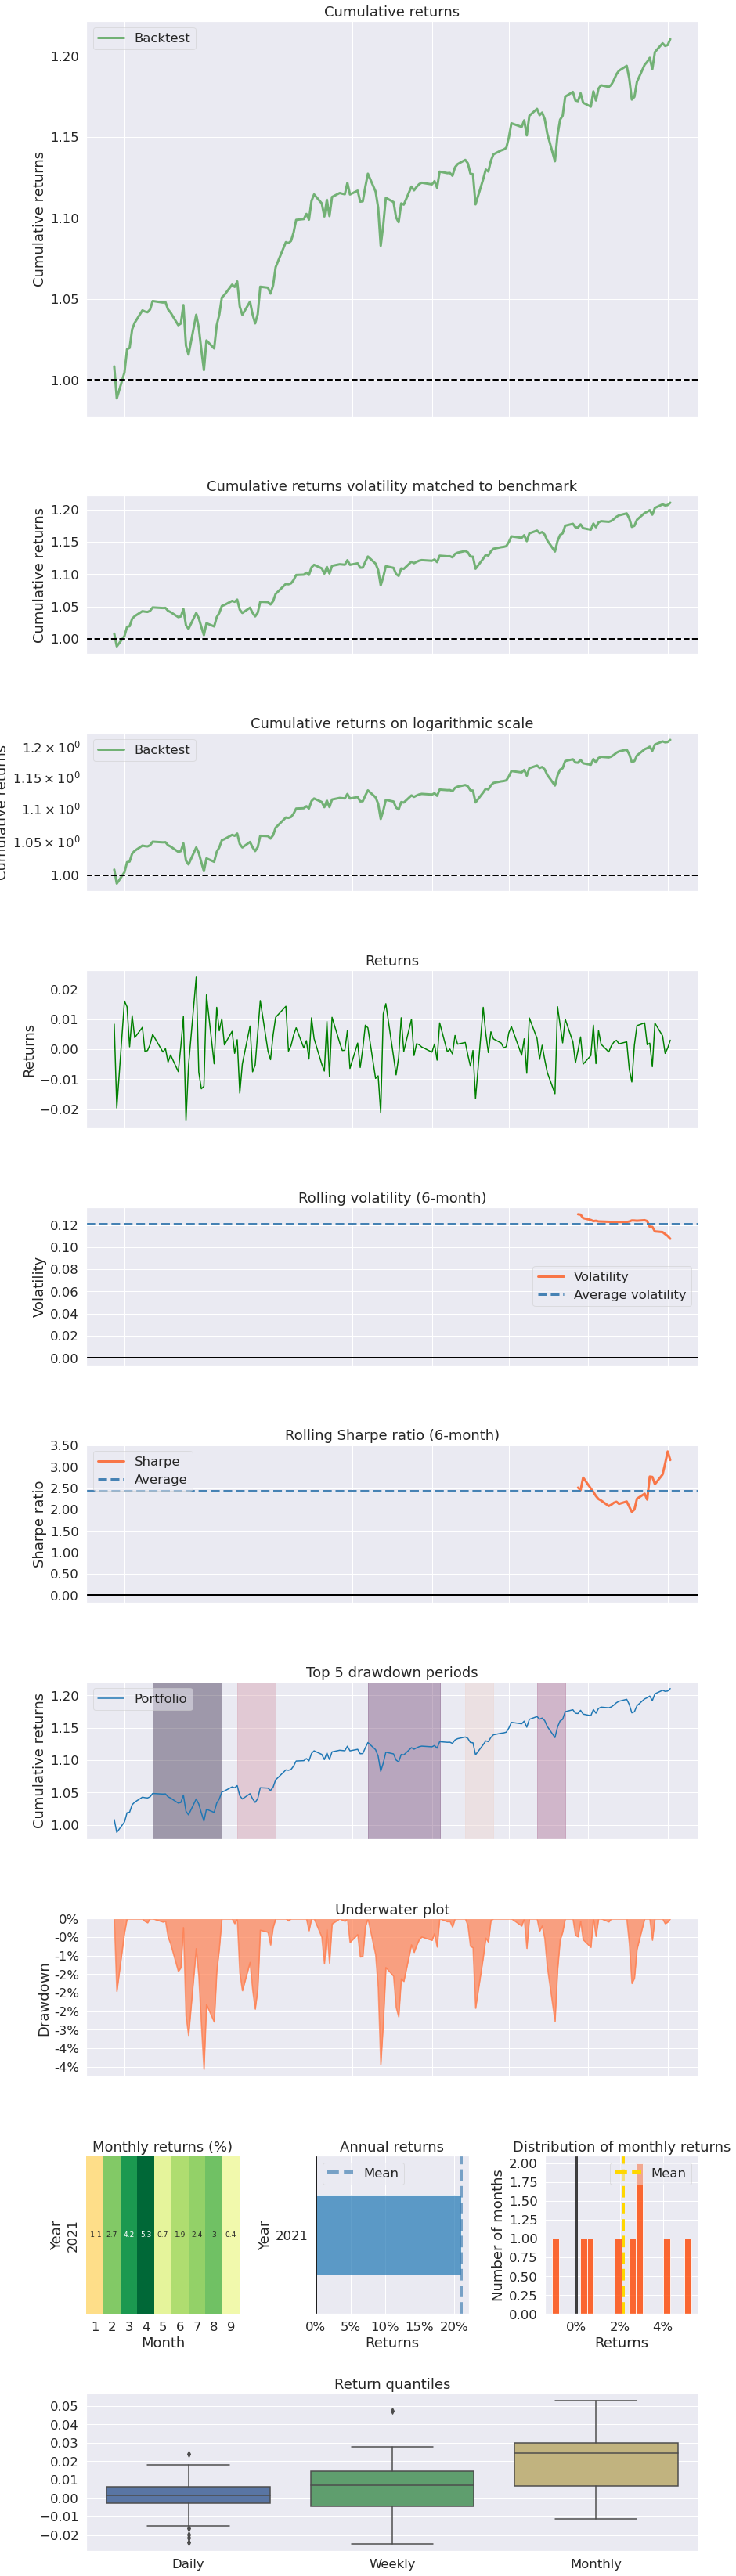

In [33]:
pf.create_returns_tear_sheet(spy_performance_series)

In [34]:
# Retain in the event that Pyfolio fails
# Not required as long as pyfolio is working correctly

#ax = df_performance_results['Strategy_Cum_Rtn'].plot(
#    kind='line', label='Trading Algo Cummulative', legend=True, 
#    title='Testing Period\nTrading Algo vs. SPY Cummulative Return', secondary_y=False, linewidth=2, style='g', figsize=(20,5))

#ax2 = df_performance_results['SPY_Cum_Rtn'].plot(
#    kind='line', label='SPY Cummulative Return', secondary_y=False, legend=True, linestyle='dashed', linewidth=1, style='r', figsize=(20,5))

#ax.legend(loc=0)
#ax.set_ylabel('Cummulative Return')

#ax2.legend(loc=3)
#ax2.set_ylabel('Cummulative Return')

#ax.legend(
#    [
#        'Trading Algo Cummulative Return',
#        'SPY Cummulative Return'
#    ]
#)

In [35]:
# Define the performance measure window size for calcuation and plotting
measure_window_size_1 = 20
measure_window_size_2 = 60

# Calculate performance measures

# rolling covariance
strat_roll_period_1_covar_spy = df_performance_results['SPY_Position'].rolling(window=measure_window_size_1).cov(df_performance_results['daily_return'])
strat_roll_period_2_covar_spy = df_performance_results['SPY_Position'].rolling(window=measure_window_size_2).cov(df_performance_results['daily_return'])

# rolling variance
strat_roll_period_1_var = df_performance_results['SPY_Position'].rolling(window=measure_window_size_1).var()
strat_roll_period_2_var = df_performance_results['SPY_Position'].rolling(window=measure_window_size_2).var()
spy_roll_period_1_var = df_performance_results['daily_return'].rolling(window=measure_window_size_1).var()
spy_roll_period_2_var = df_performance_results['daily_return'].rolling(window=measure_window_size_2).var()

# rolling standard deviation
strat_roll_period_1_std = df_performance_results['SPY_Position'].rolling(window=measure_window_size_1).std()
strat_roll_period_2_std = df_performance_results['SPY_Position'].rolling(window=measure_window_size_2).std()
spy_roll_period_1_std = df_performance_results['daily_return'].rolling(window=measure_window_size_1).std()
spy_roll_period_2_std = df_performance_results['daily_return'].rolling(window=measure_window_size_2).std()

# rolling mean
strat_roll_period_1_mean = df_performance_results['SPY_Position'].rolling(window=measure_window_size_1).mean()
strat_roll_period_2_mean = df_performance_results['SPY_Position'].rolling(window=measure_window_size_2).mean()
spy_roll_period_1_mean = df_performance_results['daily_return'].rolling(window=measure_window_size_1).mean()
spy_roll_period_2_mean = df_performance_results['daily_return'].rolling(window=measure_window_size_2).mean()


# rolling beta
strat_roll_period_1_beta = strat_roll_period_1_covar_spy / spy_roll_period_1_var
strat_roll_period_2_beta = strat_roll_period_2_covar_spy / spy_roll_period_2_var

# rolling sharpe ratio (not annualized; reflects the period sharpe ratio)
strat_roll_period_1_sharpe = strat_roll_period_1_mean / strat_roll_period_1_std
strat_roll_period_2_sharpe = strat_roll_period_2_mean / strat_roll_period_2_std
spy_roll_period_1_sharpe = spy_roll_period_1_mean / spy_roll_period_1_std
spy_roll_period_2_sharpe = spy_roll_period_2_mean / spy_roll_period_2_std

In [36]:
def chart_risk_measures_independent(title, performance_measure_name, performance_measure_data, spy_cum_test_ret, algo_cum_test_ret):
    #chart_risk_measures(title, 'Beta', strat_roll_period_1_beta, strat_roll_period_2_beta, spy_returns, algo_returns)
    '''
    This function accepts a title as string
    performance_measure as string and used for y_label
    period_1 & period_2 reflect the data containing the time series for which the performance measures
    spy_cum_test_ret reflects the cummulative return for spy
    algo_cum_test_ret reflects the cummulative return for the algo
    
    '''
    ax = spy_cum_test_ret.plot(
        kind = 'line',
        title = title,
        label = 'SPY Cummulative Return',
        secondary_y = False,
        legend = True,
        linewidth = 1,
        style = 'r',
        figsize=(20,5)
    )

    ax2 = algo_cum_test_ret.plot(
        kind='line',
        label='Trading Algo Cummulative',
        legend = True,
        secondary_y = False,
        linewidth = 1,
        style = 'g',
        figsize = (20,5)
    )    
    ax3 = performance_measure_data.plot(
        kind = 'line',
        label = 'Trading Algo Rolling Measure',
        legend = True,
        secondary_y = True,
        linestyle = 'dashed',
        linewidth = 1,
        style = 'b', 
        figsize = (20,5)
    )

    ax.legend(loc=0)
    ax2.legend(loc=0)
    ax3.legend(loc=3)

    ax.set_ylabel('Cummulative Return')
    ax3.set_ylabel(performance_measure_name)                                                    

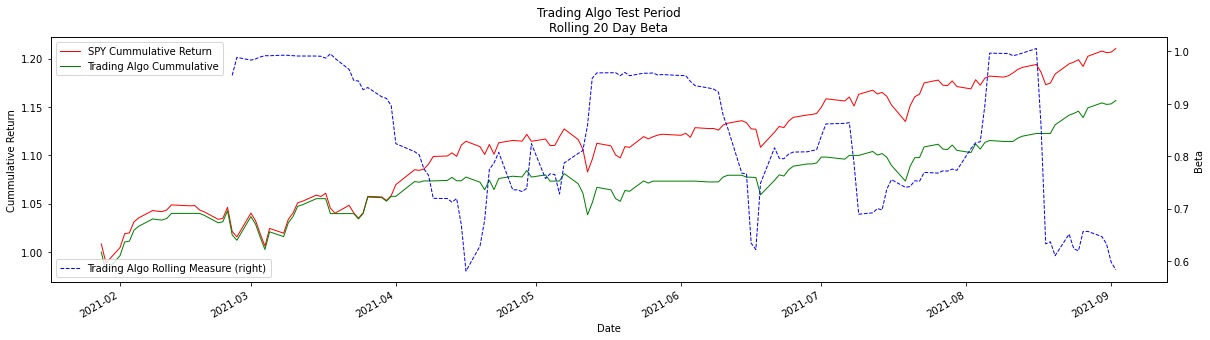

In [37]:
# Plot rolling period beta
title = (f'Trading Algo Test Period\nRolling {measure_window_size_1} Day Beta')
chart_risk_measures_independent(title, 'Beta', strat_roll_period_1_beta, df_performance_results['SPY_Cum_Rtn'], df_performance_results['Strategy_Cum_Rtn'])

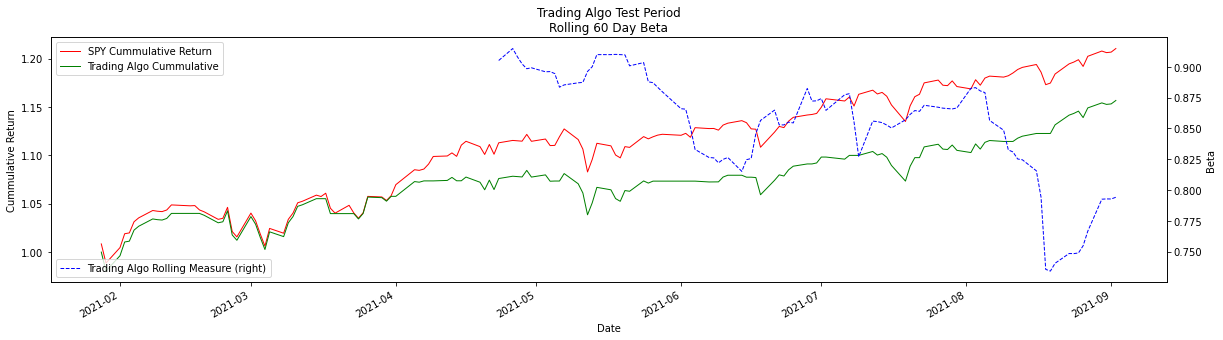

In [38]:
# Plot rolling period beta
title = (f'Trading Algo Test Period\nRolling {measure_window_size_2} Day Beta')
chart_risk_measures_independent(title, 'Beta', strat_roll_period_2_beta, df_performance_results['SPY_Cum_Rtn'], df_performance_results['Strategy_Cum_Rtn'])

In [39]:
def chart_comparables(title, df1, label1, df2, label2):
    '''
    This function accepts a title as string
    performance_measure as string and used for y_label
    period_1 & period_2 reflect the data containing the time series for which the performance measures
    spy_cum_test_ret reflects the cummulative return for spy
    algo_cum_test_ret reflects the cummulative return for the algo
    
    '''

    ax = df1.plot(
        kind = 'line',
        title = title,
        label = label1,
        secondary_y = False,
        legend = True,
        linewidth = 1,
        style = 'g',
        figsize=(20,5)
    )

    ax2 = df2.plot(
        kind = 'line',
        label = label2,
        legend = True,
        secondary_y = False,
        linewidth = 1,
        style = 'r',
        figsize = (20,5)
    )    

    ax.legend(loc=0)
    ax2.legend(loc=3)
    ax.set_ylabel('Rolling Period Sharpe Ratio')
    ax2.set_ylabel('Rolling Period Sharpe Ratio')

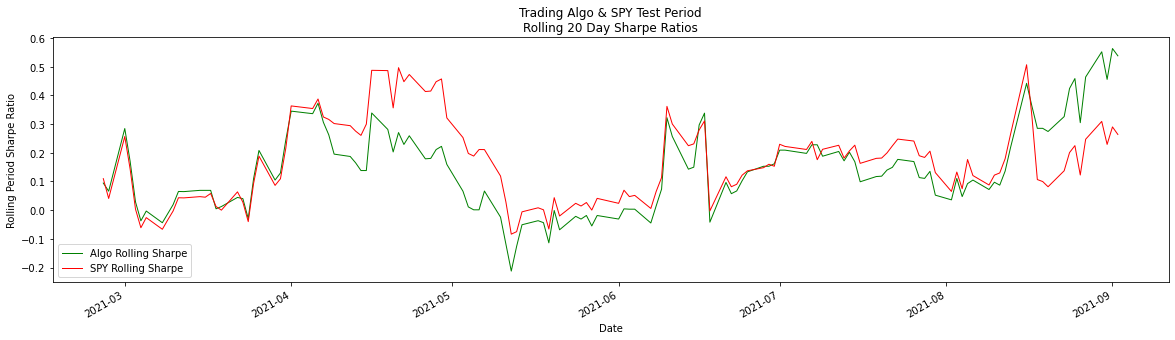

In [40]:
title = (f'Trading Algo & SPY Test Period\nRolling {measure_window_size_1} Day Sharpe Ratios')
label1 = (f'Algo Rolling Sharpe')
label2 = (f'SPY Rolling Sharpe')
chart_comparables(title, strat_roll_period_1_sharpe, label1, spy_roll_period_1_sharpe, label2)

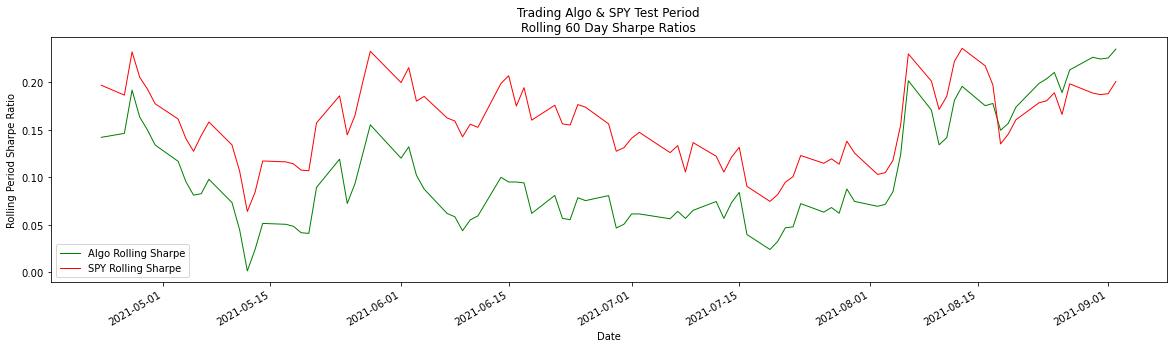

In [41]:
title = (f'Trading Algo & SPY Test Period\nRolling {measure_window_size_2} Day Sharpe Ratios')
label1 = (f'Algo Rolling Sharpe')
label2 = (f'SPY Rolling Sharpe')
chart_comparables(title, strat_roll_period_2_sharpe, label1, spy_roll_period_2_sharpe, label2)

## Save Trained Model

In [42]:
dump(model, 'model_candidates/random_rorest_model_version_0001.joblib')

['model_candidates/random_rorest_model_version_0001.joblib']